In [16]:
#Import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
def create_portfolio(n):
  '''
  Function creates a portfolio of size n.
  '''
  S0 = 100.0             # asset price
  T = 1.0                # time in years
  r = 0.02               # risk-free rate
  N = 10000              # number of time steps in simulation
  M = 1                  # number of simulations
  kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
  theta = 0.21**2        # long-term mean of variance under risk-neutral dynamics
  v0 = 0.26**2           # initial variance under risk-neutral dynamics
  sigma = 0.55
  delta = 0.0001
  Portfolio = []
  for i in range(n):
    S = S0
    kappa = kappa+i*delta
    theta = theta+i*delta
    v0 = v0+i*delta
    sigma = sigma+i*delta
    instrument = [S, kappa, theta, v0, sigma]
    Portfolio.append(instrument)
  return Portfolio

In [3]:
def create_portfolio_mean(Portfolio):
  '''
  Function creates a mean portfolio witch is used for Monte Carlo simulations after PCA
  '''
  S_m = 0
  kappa_m = 0
  theta_m = 0
  v0_m = 0
  sigma_m = 0
  for i in range(len(Portfolio)):
    S_m+=Portfolio[i][0]
    kappa_m+=Portfolio[i][1]
    theta_m+=Portfolio[i][2]
    v0_m+=Portfolio[i][3]
    sigma_m+=Portfolio[i][4]
  S_m = S_m/n
  kappa_m = kappa_m / n
  theta_m = theta_m / n
  v0_m = v0_m / n
  sigma_m = sigma_m/n
  Mean_portfolio = [S_m,kappa_m,theta_m,v0_m,sigma_m]
  return Mean_portfolio

In [11]:
def create_cov(n):
  '''
  Function creates a random covariance matrix of size n
  '''
  A = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      cov_rand = float(np.random.rand(1,1))
      A[i][j] = cov_rand
      A[j][i] = cov_rand
      A[i][i] = 1
  return A

In [4]:
def validate_cov_matrix(A):
     """
     Function validates covariance matrix for positive semidefinite property and update matrix
     """
     A = (A + A.T) * 0.5
     k = 0
     I = np.eye(A.shape[0])
     while True:
         try:
             _ = np.linalg.cholesky(A)
             break
         except np.linalg.LinAlgError:
             k += 1
             w, v = np.linalg.eig(A)
             min_eig = v.min()
             A += (-min_eig * k * k + np.spacing(min_eig)) * I
     return A

In [6]:
def create_correlated_GBMs(n):
  """
  Function creates n correlated Geometric Brownian motions of size N using Cholesky decomposition
  """
  N = 10000
  M = 1
  A = create_cov(n)
  B = validate_cov_matrix(A)

  rng = np.random.default_rng()
  mu = np.zeros(n)
  Z = rng.multivariate_normal(mu, B, (N,M), check_valid='ignore', method='cholesky')
  return Z

In [8]:
def create_dataset(Z):
  """
  Function creates dataset from correlated GBMs
  """
  new_img = Z.reshape((Z.shape[0]*Z.shape[1]), Z.shape[2])
  labels = []
  for i in range(n):
    labels.append(str(i))
  dataset = pd.DataFrame(new_img, columns = labels)
  return dataset

In [14]:
def fast_PCA(dataset, n_components):
  """
  Function computes PCA with n components from correlated GBMs
  """
  func = PCA(n_components = n_components)
  dataset_pca = func.fit_transform(dataset)

  columns = []
  for i in range(dataset_pca.shape[1]):
    columns.append(str(i))

  dataset_pca_df = pd.DataFrame(data = dataset_pca
             , columns = columns)

  return dataset_pca_df

In [9]:
def heston_model_sim(S0, v0, kappa, theta, sigma,T, N, M, Z, ind):
    """
    Function computes Monte Carlo simulations for Heston Model for n assets
    """
    r = 0.02
    dt = T/N
    mu = np.array([0,0])
    cov_rand = 0.99
    cov = np.array([[1,cov_rand],
                    [cov_rand,1]])
    rng = np.random.default_rng()
    G = rng.multivariate_normal(mu, cov, (N,M), method='cholesky')
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp((r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,ind])
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*G[i-1,:,1],0)

    return S

In [47]:
def heston_model_sim2(S0, v0, kappa, theta, sigma,T, N, M, Z, ind, dataset_df):
    """
    Function computes Monte Carlo simulations for Heston Model for assets after PCA
    """
    r = 0.02
    dt = T/N
    mu = np.array([0,0])
    cov_rand = 0.99
    cov = np.array([[1,cov_rand],
                    [cov_rand,1]])
    rng = np.random.default_rng()
    G = rng.multivariate_normal(mu, cov, (N,M), method='cholesky')
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp((r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * dataset_df[i-1])
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*G[i-1,:,1],0)

    return S

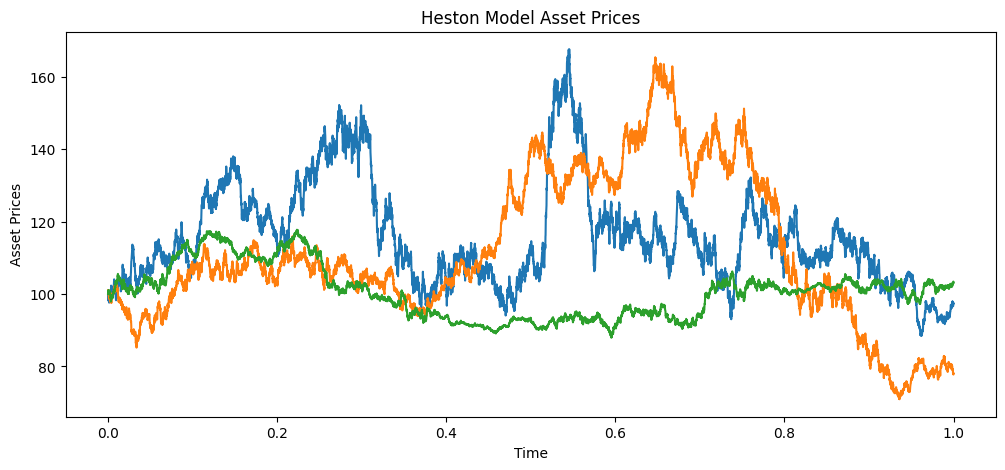

In [41]:
# Example code for computing Monte Carlo simulations for Heston Model for 7 assets after PCA (as example we take n_components = 3)
n = 7
Portfolio = create_portfolio(n)
Mean_portfolio = create_portfolio_mean(Portfolio)
Z = create_correlated_GBMs(n)
dataset = create_dataset(Z)
principal_breast_Df = fast_PCA(dataset, n_components = 3)
T = 1.0
N = 10000
M = 1
fig, ax1  = plt.subplots(1, 1, figsize=(12,5))
time = np.linspace(0,T,N+1)
Means_pca = []
for j in range(principal_breast_Df.shape[1]):
  S = heston_model_sim2(Mean_portfolio[0], Mean_portfolio[3], Mean_portfolio[1], Mean_portfolio[2], Mean_portfolio[4],T, N, M, Z, ind = j, principal_breast_Df = principal_breast_Df[str(j)])
  Means_pca.append(S.mean())
  ax1.plot(time,S,label = '{}instrument'.format(j))

ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
plt.show()

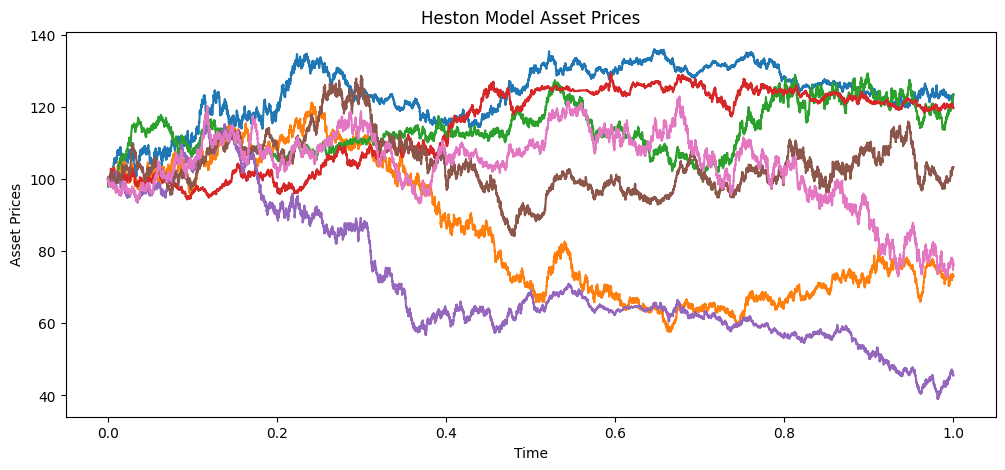

In [42]:
# Example code for computing Monte Carlo simulations for Heston Model for 10 assets

fig, ax1  = plt.subplots(1, 1, figsize=(12,5))
time = np.linspace(0,T,N+1)
Means = []
for i in range(len(Portfolio)):
  S = heston_model_sim(S0 = Portfolio[i][0], v0 = Portfolio[i][3], kappa = Portfolio[i][1], theta = Portfolio[i][2], sigma = Portfolio[i][4],T=T, N=N, M=M, Z=Z, ind = i)
  Means.append(S.mean())
  ax1.plot(time,S,label = '{}instrument'.format(i))

ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
plt.show()

In [44]:
# Let's catch an error
average = sum(Means) / len(Means)
average_pca = sum(Means_pca) / len(Means_pca)
print('Percent Error for Portfolio:', (abs(average - average_pca)/average)*100, '%')

Percent Error for Portfolio: 6.968781604206847 %


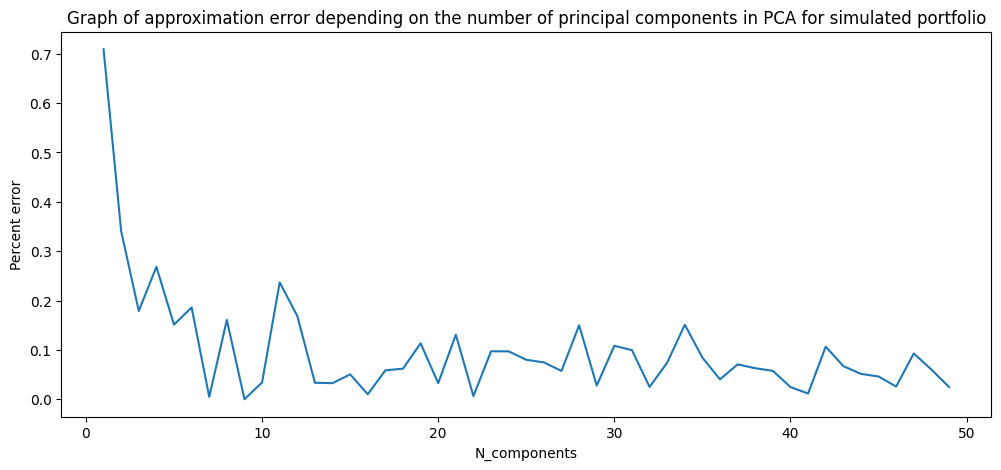

In [55]:
# Now Let's try to do some experiments. First assume we have portfolio of size n = 50 assets. And let's try to compute best n_components for PCA
# for simulated portfolio
# Be careful! It takes about 20 min to compute !
fig, ax1  = plt.subplots(1, 1, figsize=(12,5))
iterations = []
errors_total = []
for k in range(1):
  errors = []
  n = 50
  Portfolio = create_portfolio(n)
  Mean_portfolio = create_portfolio_mean(Portfolio)
  Z = create_correlated_GBMs(n)
  dataset = create_dataset(Z)
  for i in range(1,50):
    iterations.append(i)
    dataset_df = fast_PCA(dataset, n_components = i)
    T = 1.0
    N = 10000
    M = 1

    Means_pca = []
    for j in range(dataset_df.shape[1]):
      S = heston_model_sim2(Mean_portfolio[0], Mean_portfolio[3], Mean_portfolio[1], Mean_portfolio[2], Mean_portfolio[4],T, N, M, Z, ind = j, dataset_df = dataset_df[str(j)])
      Means_pca.append(S.mean())

    Means = []
    for i in range(len(Portfolio)):
      S = heston_model_sim(S0 = Portfolio[i][0], v0 = Portfolio[i][3], kappa = Portfolio[i][1], theta = Portfolio[i][2], sigma = Portfolio[i][4],T=T, N=N, M=M, Z=Z, ind = i)
      Means.append(S.mean())

    average = sum(Means) / len(Means)
    average_pca = sum(Means_pca) / len(Means_pca)
    MAPE = abs(average - average_pca)/average
    errors.append(MAPE)

  errors_total.append(errors)

  plt.plot(iterations, errors)
  ax1.set_title('Graph of approximation error depending on the number of principal components in PCA for simulated portfolio')
  ax1.set_xlabel('N_components')
  ax1.set_ylabel('Percent error')

In [56]:
# Let's take n_components with the lowest error
print('Best number for n_components:', (errors.index(min(errors))+1))

Best number for n_components: 9


Text(0, 0.5, 'Percent error')

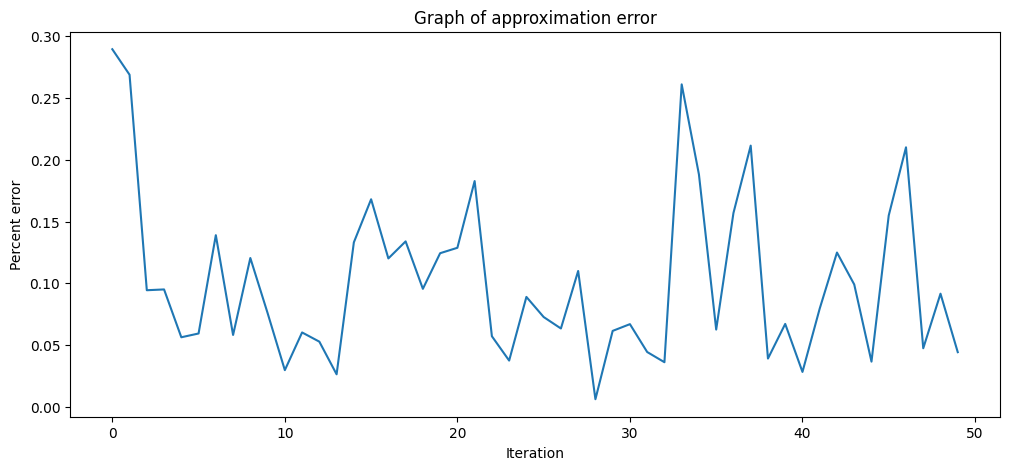

In [66]:
#Now lets take n_components = 9 as we got above and run 50 times Monte Carlo simulation to get average error
# Be careful. It takes about 20 min to compute !
fig, ax1  = plt.subplots(1, 1, figsize=(12,5))
iterations = []
errors = []
n_components = 9
for i in range(50):
  iterations.append(i)
  dataset_df = fast_PCA(dataset, n_components = n_components)
  T = 1.0
  N = 10000
  M = 1

  Means_pca = []
  for j in range(dataset_df.shape[1]):
    S = heston_model_sim2(Mean_portfolio[0], Mean_portfolio[3], Mean_portfolio[1], Mean_portfolio[2], Mean_portfolio[4],T, N, M, Z, ind = j, dataset_df = dataset_df[str(j)])
    Means_pca.append(S.mean())

  Means = []
  for i in range(len(Portfolio)):
    S = heston_model_sim(S0 = Portfolio[i][0], v0 = Portfolio[i][3], kappa = Portfolio[i][1], theta = Portfolio[i][2], sigma = Portfolio[i][4],T=T, N=N, M=M, Z=Z, ind = i)
    Means.append(S.mean())

  average = sum(Means) / len(Means)
  average_pca = sum(Means_pca) / len(Means_pca)
  MAPE = abs(average - average_pca)/average
  errors.append(MAPE)

plt.plot(iterations, errors)
ax1.set_title('Graph of approximation error')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Percent error')

In [73]:
print('Average percent error for 50 asset Portfolio after PCA approximation with 9 components:', 100*(sum(errors) / len(errors)), '%')

Average percent error for 50 asset Portfolio after PCA approximation with 9 components: 10.123419233915476 %


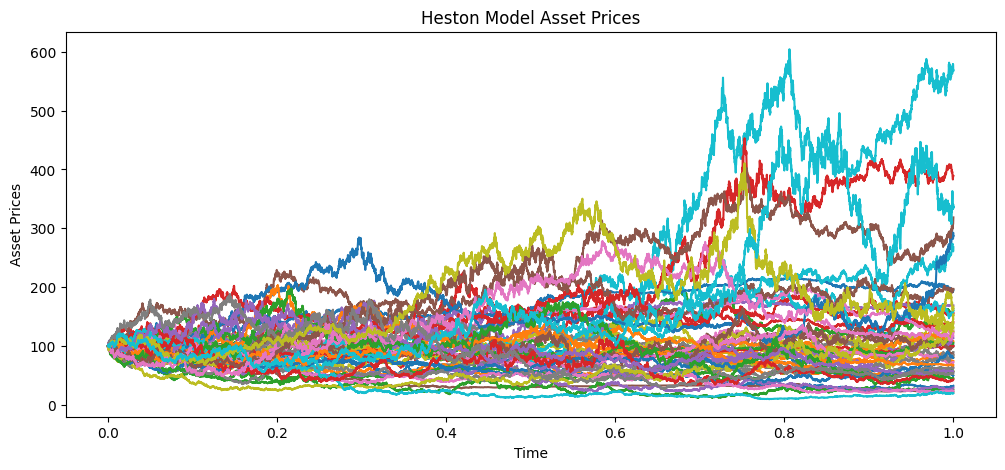

CPU times: user 15.2 s, sys: 912 ms, total: 16.1 s
Wall time: 16 s


In [76]:
# Let's plot Monte Carlo paths for portfolio
%%time
fig, ax1  = plt.subplots(1, 1, figsize=(12,5))
for i in range(len(Portfolio)):
  S = heston_model_sim(S0 = Portfolio[i][0], v0 = Portfolio[i][3], kappa = Portfolio[i][1], theta = Portfolio[i][2], sigma = Portfolio[i][4],T=T, N=N, M=M, Z=Z, ind = i)

  ax1.plot(time,S,label = '{}instrument'.format(j))
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
plt.show()

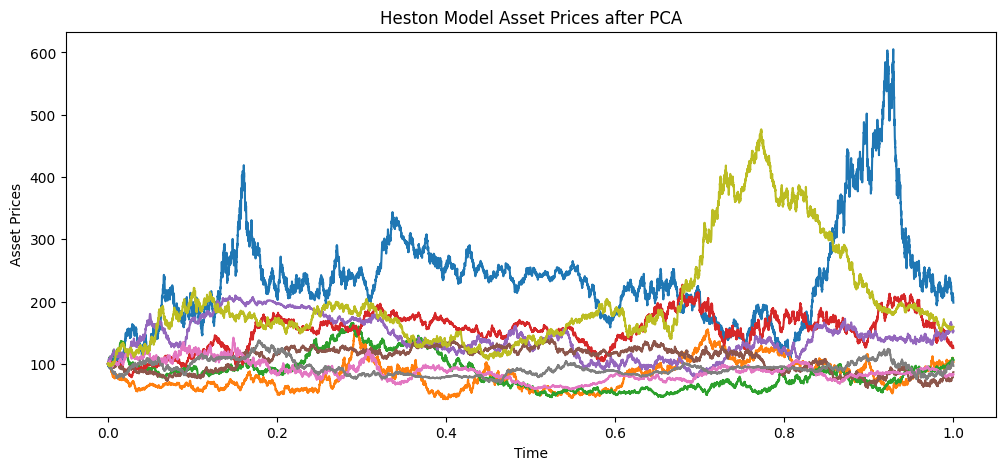

CPU times: user 3.62 s, sys: 331 ms, total: 3.95 s
Wall time: 3.87 s


In [77]:
#Let's plot Monte Carlo paths for portfolio after PCA
%%time
fig, ax1  = plt.subplots(1, 1, figsize=(12,5))
for j in range(dataset_df.shape[1]):
  S = heston_model_sim2(Mean_portfolio[0], Mean_portfolio[3], Mean_portfolio[1], Mean_portfolio[2], Mean_portfolio[4],T, N, M, Z, ind = j, dataset_df = dataset_df[str(j)])

  ax1.plot(time,S,label = '{}instrument'.format(j))
ax1.set_title('Heston Model Asset Prices after PCA')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
plt.show()

In [ ]:
# We speeded up our computations from 16.1s to 3.95s using PCA with error about 10%